# 3. Compare data-based and model-based time-series prediction
(Note that in the following “model” means ODE-model.)
Use the number of confirmed cases (a) from one of your SIR scenarios and (b) from one of your
agent-based scenarios. Choose some appropriate training and prediction range
1. Fit your best SIR-based model to the data.
2. Use the best approach from the previous section.
3. Compare the results of the approaches (qualitatively and using the Root Mean Squared Error).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
from scipy.integrate import odeint

### Helper Functions

In [12]:
# ODE system
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, alpha_t, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * alpha_t(t) * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - alpha_t(t)) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - alpha_t(t)) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * alpha_t(t) * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [48]:
gamma = 1.0/9.0 # the proportion of infected recovering per day
sigma = 1.0/3.0 # 1 devided by the incubation period in days

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003
    
    # the death rate as a time dependent function, with factor age, previous conditions and decline over time through better treatment availability
    def alpha_t(t):
        return min(1.0,(a_0_start-a_0_end) / (1 + np.exp(-k2*(-t+x2_0))) + a_0_end + s1 * alpha_opt_1 + s2 * alpha_opt_2)
#     def alpha_t(t):
#         return (max(0.0, (alpha_start + t * alpha_change + s1 * alpha_opt_1 + s2 * alpha_opt_2) ))

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, alpha_t, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    alpha_t_over_time = [alpha_t(i) for i in t]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time

In [14]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU, from: {S_2[0] * 100}, to:{S_2[-1] * 100}")


    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
        ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
        ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')



    ax.title.set_text('extended SEIR-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    
    f, ax = plt.subplots(1,1,figsize=(20,4))
    if x_ticks is None:
#         ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    else:
#         ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
        ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')



    ax.title.set_text('extended SEIR-Model zoomed')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();
    
    print("final numbers: S: {:.0f} E: {:.0f} I: {:.0f} C: {:.0f} R: {:.0f} D: {:.0f}".format(S[-1],E[-1],I[-1],C[-1],R[-1],D[-1]))
    
    f = plt.figure(figsize=(20,8))
    # sp1
    ax1 = f.add_subplot(221)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
    # sp2
    ax4 = f.add_subplot(222)
    if x_ticks is None:
        ax4.plot(t, S_2, 'b--', alpha=0.7, linewidth=2, label='alpha_t')
    else:
        ax4.plot(x_ticks, S_2, 'b--', alpha=0.7, linewidth=2, label='alpha_t')

 
    ax4.title.set_text('alpha_t over time')
    ax4.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax4.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    
    # sp3
    ax2 = f.add_subplot(223)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    # sp4
    ax3 = f.add_subplot(224)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

## 3.1. a) Fit your best SIR-based model to the SEICRD data.

### 3.1.a.1 Load SEICRD generated data

In [2]:
SEICRD_data = pd.read_csv('correct_counting_for_rki_dataset_and_SEICRD/SEICRD_daily.csv', sep=",")
SEICRD_data["Date"] = pd.to_datetime(SEICRD_data.iloc[:,0], format='%Y/%m/%d %H:%M:%S.%f')
SEICRD_data["Date"] = SEICRD_data['Date'].dt.date
SEICRD_data.head()

FileNotFoundError: [Errno 2] File SEICRD_daily.csv does not exist: 'SEICRD_daily.csv'

### 3.1.a.2 Get the number of confirmed cases (Infected) as training and testing set

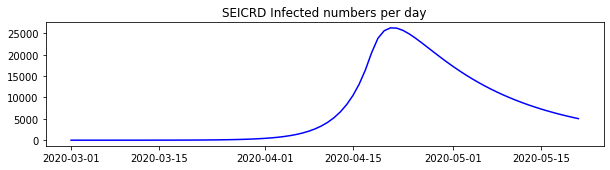

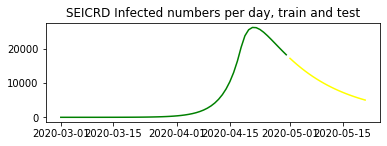

In [101]:
infected_per_day = SEICRD_data.groupby("Date")['I'].sum()
training_data_daily = infected_per_day[datetime.date(2020,3,1):datetime.date(2020,4,30)]
# cumulative number
training_data_cum = training_data_daily.cumsum().values
valid_data_daily = infected_per_day[datetime.date(2020,5,1):]
# cumulative number
valid_data_cum = valid_data_daily.cumsum().values + training_data_cum[len(training_data_cum)-1]

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(infected_per_day, color="blue")
plt.title("SEICRD Infected numbers per day")
plt.show()
plt.subplot(212)
plt.plot(training_data_daily, color="green")
plt.plot(valid_data_daily, color="yellow")
plt.title("SEICRD Infected numbers per day, train and test")
plt.show()

### 3.1.a.3 Fit the SEICRD model to the data

In [16]:
# parameters
# set the total population number
# from here: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/zensus-geschlecht-staatsangehoerigkeit-2019.html;jsessionid=B6506D714A8218B0616748EA21EBBFB1.internet8721
N = 83149300
# for the agegroups take demographics percentages from 2018 data and apply to N
# from here: https://de.statista.com/statistik/daten/studie/1351/umfrage/altersstruktur-der-bevoelkerung-deutschlands/
# 0-14, 14-34, 35-59, 60-79, 80+
total_2018 = 83019000.0
age_percentages_2018 = [11290815/total_2018, 19213113/total_2018, 29137839/total_2018, 
                        17988340/total_2018, 5389106/total_2018]
agegroups = [N * x for x in age_percentages_2018] 
deaths_per_agegroup = [1, 16, 351, 2595, 5210]
total_deaths = sum(deaths_per_agegroup)
alpha_by_agegroup = {"0-14": deaths_per_agegroup[0]/total_deaths, "15-34": deaths_per_agegroup[1]/total_deaths, 
                     "35-59": deaths_per_agegroup[2]/total_deaths, "60-79": deaths_per_agegroup[3]/total_deaths, "80+": deaths_per_agegroup[4]/total_deaths}
proportion_of_agegroup = {"0-14": age_percentages_2018[0], "15-34": age_percentages_2018[1], 
                          "35-59": age_percentages_2018[2], "60-79": age_percentages_2018[3], "80+": age_percentages_2018[4]}

# for the prevoius conditions take the death rate by previous condition 
# from here: https://de.statista.com/statistik/daten/studie/1102109/umfrage/mortalitaetsrate-des-coronavirus-nach-vorerkrankung/
alpha_by_condition = {"nothing": 0.0, "other": 0.08, "pulmonary": 0.13}
proportion_of_condition = {"nothing": 0.3, "other": 0.6, "pulmonary": 0.1}

# from here: https://www.tagesspiegel.de/wissen/grosse-datenanalyse-zu-krankenhaeusern-hier-koennten-die-intensivbetten-in-deutschland-knapp-werden/25746240.html
total_beds = 33500
beds_per_100k = total_beds * 100000 / N

# add a factor to the deathrate depending on demographics and previous conditions
alpha_opt_1 = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))
alpha_opt_2 = sum(alpha_by_condition[i] * proportion_of_condition[i] for i in list(alpha_by_condition.keys()))

# set parameters for fitting, form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (20, 0,50), "R_0_end": (0.9, 0.3, 1.0),
                       "prob_I_to_C": (0.05, 0.01, 0.3), 
                       "a_0_start": (0.5, 0.0, 0.7), "k2": (2.5, 0.01, 5.0), "x2_0": (20, 0, 50), "a_0_end": (0.2, 0.01, 0.7),
                      "s": (0.003, 0.001, 0.01), "s1": (0.3, 0.0, 0.6), "s2": (0.3, 0.0, 0.6)} 

In [40]:
# Outputs of Model, fit to infected: t, S, E, ->I<-, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time
def fitter(x, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2)
    return ret[3][x]

In [43]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [53]:
days = len(training_data_daily)
x_data = np.linspace(0, days - 1, days, dtype=int)
result = mod.fit(training_data_daily, params, method="least_squares", x=x_data)

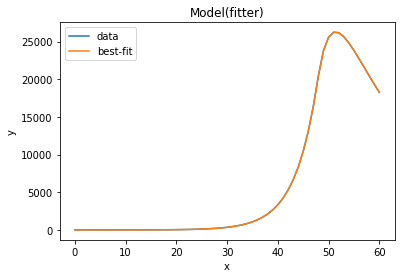

In [54]:
result.plot_fit(datafmt="-");

Prediction for Germany
percentage going to ICU: 29.999999950815077; percentage dying in ICU, from: 27.534577911324426, to:52.51374567875195


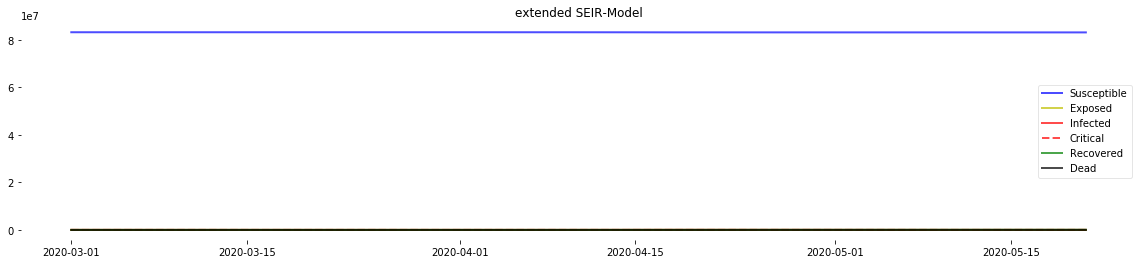

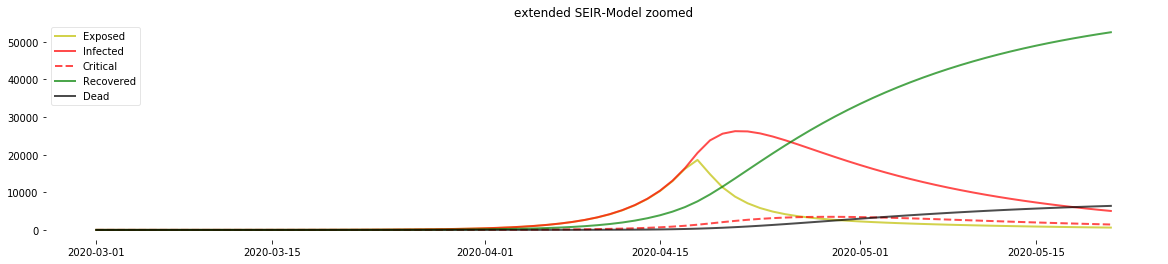

final numbers: S: 83083262 E: 618 I: 5040 C: 1440 R: 52552 D: 6388


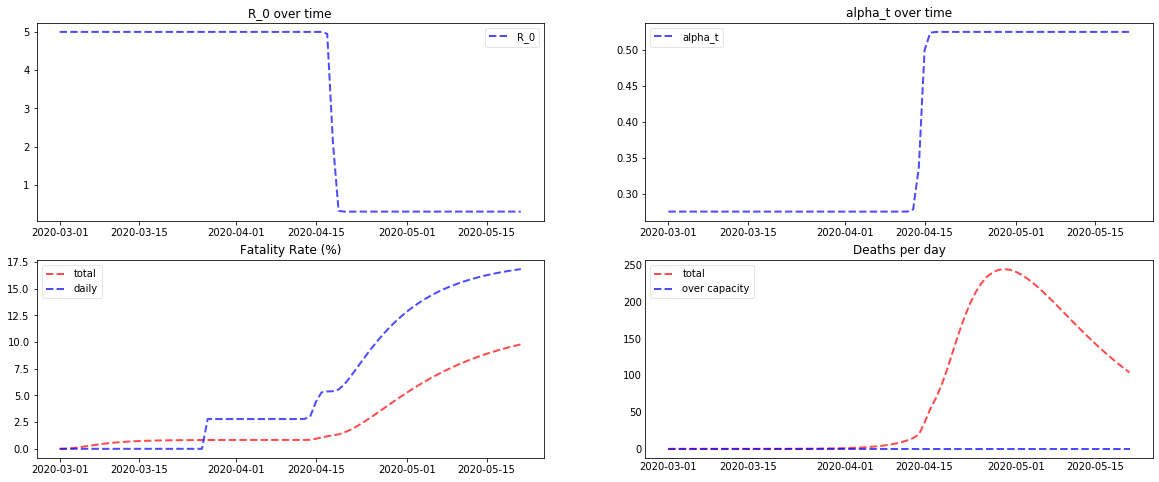

In [56]:
# set full_days to training + testing range
full_days = len(training_data_daily) + len(valid_data_daily)
first_date = training_data_daily.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Germany")
plotter(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

### 3.1.a.4 Test the SEICRD model prediction

In [73]:
# Outputs of Model, get infected: t, S, E, ->I<-, C, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time
predicted_infected_daily = Model(full_days, agegroups, beds_per_100k, **result.best_values)[3][len(training_data_daily):]
predicted_infected_daily = pd.Series(predicted_infected_daily, index=valid_data_daily.index)

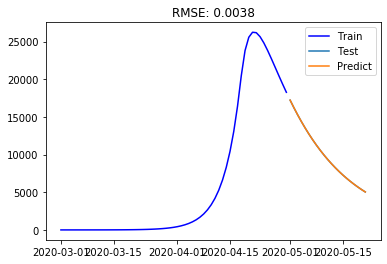

In [113]:
plt.plot(training_data_daily, color="blue", label="Train")
plt.plot(valid_data_daily, label="Test")
plt.plot(predicted_infected_daily, label="Predict")
plt.title("RMSE: %.4f"% np.sqrt(np.sum((predicted_infected_daily-valid_data_daily)**2)/len(valid_data_daily)))
plt.legend(loc="best")
plt.show()

## 3.1. b) Fit your best SIR-based model to the ABM data.

### 3.1.b.1 Load ABM generated data

In [76]:
ABM_data = pd.read_csv("correct_counting_for_rki_dataset_and_SEICRD/do_nothing_reduced.csv", sep=",")
ABM_data.head()

,Iteration,Metric,Min,Avg,Std,Max
0,0,Susceptible,0.968,0.969333,0.000943,0.970
1,0,Infected,0.020,0.020667,0.000943,0.022
2,0,Recovered_Immune,0.010,0.010000,0.000000,0.010
3,0,Death,0.000,0.000000,0.000000,0.000
4,0,Exposed,0.000,0.000667,0.000943,0.002


### 3.1.b.2 Get the number of confirmed cases (Infected) as training and testing set

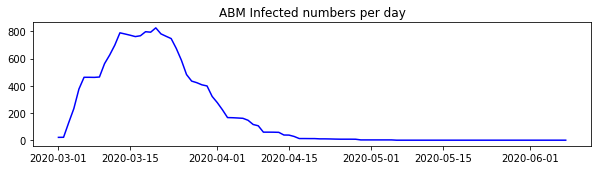

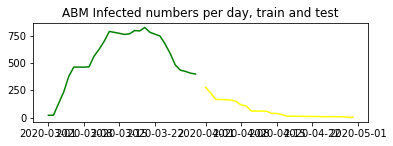

In [102]:
population_size = 1000 

ABM_data_ = pd.DataFrame() 
ABM_data_['infected']= ABM_data[1::14]['Avg'] * population_size
ABM_data_['Date'] = pd.date_range('3/1/2020', periods=len(ABM_data_['infected']), freq='D')

ABM_data_ = ABM_data_.reset_index(drop=True)
ABM_data_ = ABM_data_.set_index('Date', drop=True)

# select training data from 01.03 to 30.03
training_data = ABM_data_[datetime.date(2020,3,1):datetime.date(2020,3,30)]['infected']

# select validate data from 01.04 to 30.04
valid_data = ABM_data_[datetime.date(2020,4,1):datetime.date(2020,4,30)]['infected']

plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ABM_data_['infected'], color="blue")
plt.title("ABM Infected numbers per day")
plt.show()
plt.subplot(212)
plt.plot(training_data, color="green")
plt.plot(valid_data, color="yellow")
plt.title("ABM Infected numbers per day, train and test")
plt.show()

### 3.1.b.3 Fit the SEICRD model to the data

In [94]:
# parameters
# set the total population number
# from here: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Bevoelkerungsstand/Tabellen/zensus-geschlecht-staatsangehoerigkeit-2019.html;jsessionid=B6506D714A8218B0616748EA21EBBFB1.internet8721
N = population_size
# for the agegroups take demographics percentages from 2018 data and apply to N
# from here: https://de.statista.com/statistik/daten/studie/1351/umfrage/altersstruktur-der-bevoelkerung-deutschlands/
# 0-14, 14-34, 35-59, 60-79, 80+
total_2018 = 83019000.0
age_percentages_2018 = [11290815/total_2018, 19213113/total_2018, 29137839/total_2018, 
                        17988340/total_2018, 5389106/total_2018]
agegroups = [N * x for x in age_percentages_2018] 
deaths_per_agegroup = [1, 16, 351, 2595, 5210]
total_deaths = sum(deaths_per_agegroup)
alpha_by_agegroup = {"0-14": deaths_per_agegroup[0]/total_deaths, "15-34": deaths_per_agegroup[1]/total_deaths, 
                     "35-59": deaths_per_agegroup[2]/total_deaths, "60-79": deaths_per_agegroup[3]/total_deaths, "80+": deaths_per_agegroup[4]/total_deaths}
proportion_of_agegroup = {"0-14": age_percentages_2018[0], "15-34": age_percentages_2018[1], 
                          "35-59": age_percentages_2018[2], "60-79": age_percentages_2018[3], "80+": age_percentages_2018[4]}

# for the prevoius conditions take the death rate by previous condition 
# from here: https://de.statista.com/statistik/daten/studie/1102109/umfrage/mortalitaetsrate-des-coronavirus-nach-vorerkrankung/
alpha_by_condition = {"nothing": 0.0, "other": 0.08, "pulmonary": 0.13}
proportion_of_condition = {"nothing": 0.3, "other": 0.6, "pulmonary": 0.1}

# from here: https://www.tagesspiegel.de/wissen/grosse-datenanalyse-zu-krankenhaeusern-hier-koennten-die-intensivbetten-in-deutschland-knapp-werden/25746240.html
total_beds = 33500
beds_per_100k = total_beds * 100000 / N

# add a factor to the deathrate depending on demographics and previous conditions
alpha_opt_1 = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))
alpha_opt_2 = sum(alpha_by_condition[i] * proportion_of_condition[i] for i in list(alpha_by_condition.keys()))

# set parameters for fitting, form: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (20, 0,50), "R_0_end": (0.9, 0.3, 1.0),
                       "prob_I_to_C": (0.05, 0.01, 0.3), 
                       "a_0_start": (0.5, 0.0, 0.7), "k2": (2.5, 0.01, 5.0), "x2_0": (20, 0, 50), "a_0_end": (0.2, 0.01, 0.7),
                      "s": (0.003, 0.001, 0.01), "s1": (0.3, 0.0, 0.6), "s2": (0.3, 0.0, 0.6)} 

In [103]:
# Outputs of Model, fit to EIC: t, S, ->E, I, C<-, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time
def fitter(x, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, a_0_start, k2, x2_0, a_0_end, prob_I_to_C, s, s1, s2)
    return ret[2][x] + ret[3][x] + ret[4][x]

In [104]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

In [105]:
days = len(training_data)
x_data = np.linspace(0, days - 1, days, dtype=int)
result = mod.fit(training_data, params, method="least_squares", x=x_data)

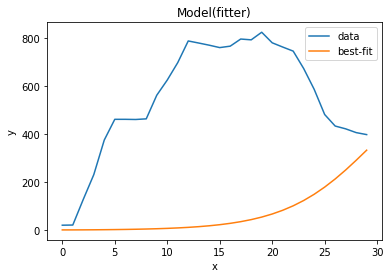

In [106]:
result.plot_fit(datafmt="-");

Prediction for Germany
percentage going to ICU: 29.999999998890175; percentage dying in ICU, from: 81.20321396569685, to:73.55741170985107


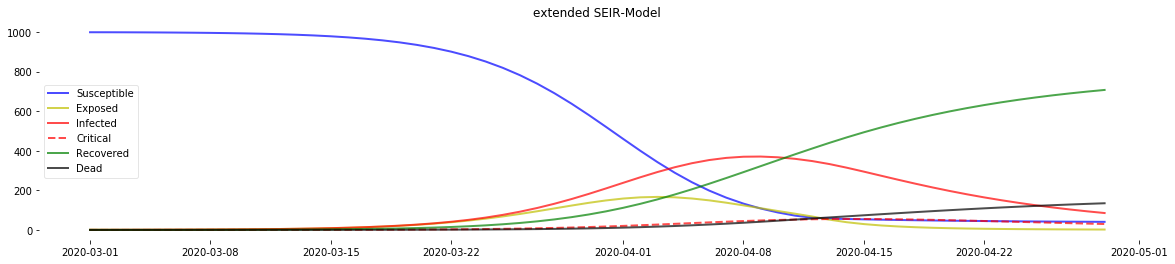

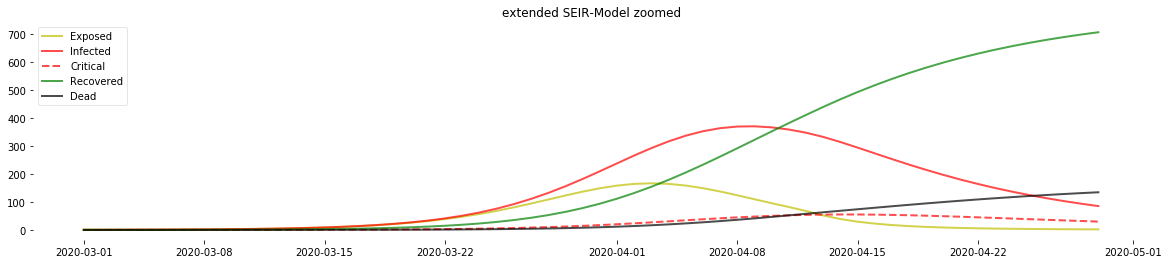

final numbers: S: 41 E: 2 I: 85 C: 30 R: 707 D: 135


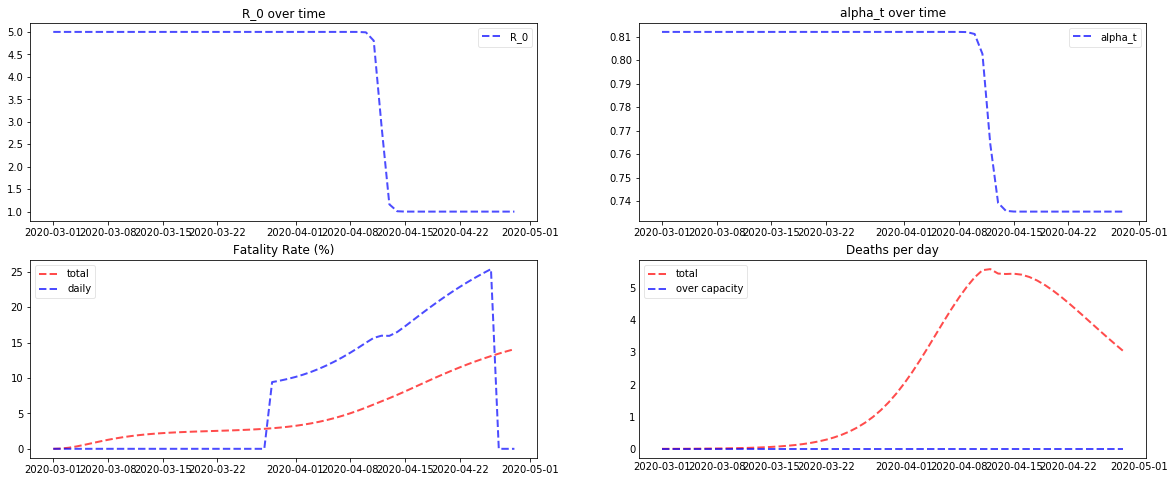

In [107]:
# set full_days to training + testing range
full_days = len(training_data) + len(valid_data)
first_date = training_data.index[0]
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Germany")
plotter(*Model(full_days, agegroups, beds_per_100k, **result.best_values), x_ticks=x_ticks);

### 3.1.b.4 Test the SEICRD model prediction

In [110]:
# Outputs of Model, get EIC: t, S, ->E, I, C<-, R, D, R_0_over_time, Beds, prob_I_to_C, alpha_t_over_time
predicted_infected = Model(full_days, agegroups, beds_per_100k, **result.best_values)[3][len(training_data):] + Model(full_days, agegroups, beds_per_100k, **result.best_values)[2][len(training_data):] + Model(full_days, agegroups, beds_per_100k, **result.best_values)[4][len(training_data):]
predicted_infected = pd.Series(predicted_infected, index=valid_data.index)

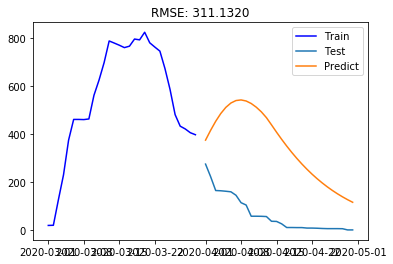

In [112]:
plt.plot(training_data, color="blue", label="Train")
plt.plot(valid_data, label="Test")
plt.plot(predicted_infected, label="Predict")
plt.title("RMSE: %.4f"% np.sqrt(np.sum((predicted_infected-valid_data)**2)/len(valid_data)))
plt.legend(loc="best")
plt.show()